# Project 1 - Finite differences

Many physics codes only provide objective values and are not able to compute their gradients. In that case, the derivative is often approximated using finite differences. The goal of this project is to implement your own finite difference approximation and investigate the impact of round-off error as well as the increase in runtime compared to analytical gradient computation.

In [20]:
# Lets begin by setting up our toy problem again.
from pyplasmaopt import *
nfp = 2
(coils, currents, magnetic_axis, eta_bar) = get_24_coil_data(nfp=nfp, ppp=10, at_optimum=False)
stellarator = CoilCollection(coils, currents, nfp, True)
iota_target = 0.103
coil_length_target = 4.398229715025710
magnetic_axis_length_target = 6.356206812106860
eta_bar = -2.25
obj = SimpleNearAxisQuasiSymmetryObjective(
        stellarator, magnetic_axis, iota_target, eta_bar=eta_bar,
        coil_length_target=coil_length_target, magnetic_axis_length_target=magnetic_axis_length_target)

A first order approximation to the derivative at $x$ in direction of the $i$-th degree of freedom is given by
$$ (\nabla f(x))_i= \frac{f(x+\epsilon e_i) - f(x)}{\epsilon} + O(\epsilon). $$

The following code will compute the gradient in a direction $h$ and compares it to the derivative that the code computes for us.

In [23]:
def compute_directional_derivative_fd(obj, x, h, eps):
    obj.update(x, compute_derivative=False)
    fx = obj.res
    obj.update(x+eps*h, compute_derivative=False)
    fxh = obj.res
    return (fxh-fx)/eps

x = obj.x0
h = np.random.rand(*(x.shape))
obj.update(x)
derivative = np.sum(obj.dres*h)
eps = 1e-6
fd_derivative = compute_directional_derivative_fd(obj, x, h, eps)
print('Exact derivative =', derivative)
print('Finite differences derivative =', fd_derivative)
print('Error =', abs(derivative-fd_derivative))

Exact derivative = 27.25753460060907
Finite differences derivative = 27.372776710166136
Error = 0.11524210955706593


## Tasks

1. Vary the stepsize $\epsilon$. As $\epsilon\to0$, how does the error behave?
2. Look up the 2nd, 4th, and 6th order finite difference stencils on wikipedia and implement them. Show a plot comparing the step size $\epsilon$ with the approximation error. What do you observe?
3. The `minimize` function in scipy supports finite differences to compute the gradient. To use this, set the argument `jac=False` and make sure that the function you pass to minimise only returns the objective value, and not both objective and gradient. Now run the optimisation once with exact gradients and once using the scipy finite difference approximation for 500 iterations. Compare the runtime of the two and plot the objective values. What to do you observe? Call `print` on the object that `minimize` returns to find out why each algorithm terminated.

*Note*: If you pass `callback=obj.callback` to `minimize`, then the objective history will be stored in `obj.Jvals`. Beore running a second optimisation, you can reset this history by calling `obj.clear_history()`.

## Solutions

### Task 1

In [25]:
for eps in [10**(-i) for i in range(5, 14)]:
    fd_derivative = compute_directional_derivative_fd(obj, x, h, eps)
    err = abs(derivative-fd_derivative)
    print(eps, err)

1e-05 1.1524021685490773
1e-06 0.11524210955706593
1e-07 0.011524214839873537
1e-08 0.0011520850181838682
1e-09 0.00011753479491716234
1e-10 1.391561119845619e-05
1e-11 0.0003058286198935889
1e-12 0.0011152568516266115
1e-13 0.008220684209227613


### Task 2

In [28]:
def compute_directional_derivative_fd_ho(obj, x, h, eps, order):
    if order == 1:
        shifts = [0, 1]
        weights = [-1, 1]
    elif order == 2:
        shifts = [-1, 1]
        weights = [-0.5, 0.5]
    elif order == 4:
        shifts = [-2, -1, 1, 2]
        weights = [1/12, -2/3, 2/3, -1/12]
    elif order == 6:
        shifts = [-3, -2, -1, 1, 2, 3]
        weights = [-1/60, 3/20, -3/4, 3/4, -3/20, 1/60]
    obj.update(x + shifts[0]*eps*h, compute_derivative=False)
    fd = weights[0] * obj.res
    for i in range(1, len(shifts)):
        obj.update(x + shifts[i]*eps*h, compute_derivative=False)
        fd += weights[i] * obj.res
    return fd/eps

err1 = []
err2 = []
err4 = []
err6 = []
epss = [2**(-i) for i in range(10, 40)]
for eps in epss:
    fd1 = compute_directional_derivative_fd_ho(obj, x, h, eps, 1)
    err1.append(abs(derivative-fd1))
    fd2 = compute_directional_derivative_fd_ho(obj, x, h, eps, 2)
    err2.append(abs(derivative-fd2))
    fd4 = compute_directional_derivative_fd_ho(obj, x, h, eps, 4)
    err4.append(abs(derivative-fd4))
    fd6 = compute_directional_derivative_fd_ho(obj, x, h, eps, 6)
    err6.append(abs(derivative-fd6))

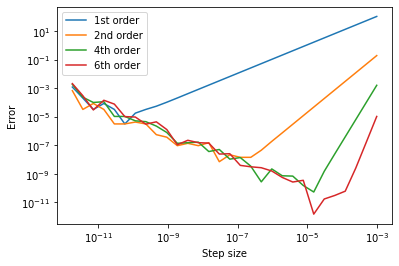

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.loglog(epss, err1, label="1st order")
plt.loglog(epss, err2, label="2nd order")
plt.loglog(epss, err4, label="4th order")
plt.loglog(epss, err6, label="6th order")
plt.legend()
plt.xlabel('Step size')
plt.ylabel('Error')
plt.show()

### Task 3

In [30]:
%%time
from scipy.optimize import minimize
x = res.x
obj.clear_history()
def scipy_fun_fd(x):
    obj.update(x, compute_derivative=False)
    res = obj.res
    return res

res = minimize(scipy_fun_fd, obj.x0, jac=False, method='bfgs', tol=1e-20,
               options={"maxiter": 500},
               callback=obj.callback)
print(res)
convergence_fd = obj.Jvals

INFO ################################################################################
INFO Iteration 0
INFO Objective value:         1.093822e+01
INFO Objective gradients:     1.918065e-01, 7.717689e+01, 2.878846e+01, 2.407059e-02
INFO Curvature Max: 1.429e+00; Mean: 1.429e+00
INFO Torsion   Max: 5.751e-10; Mean: 1.946e-10
INFO ################################################################################
INFO Iteration 1
INFO Objective value:         1.092079e+01
INFO Objective gradients:     1.908316e-01, 4.332980e+01, 2.876623e+01, 2.868100e-02
INFO Curvature Max: 1.429e+00; Mean: 1.429e+00
INFO Torsion   Max: 6.959e-07; Mean: 2.477e-07
INFO ################################################################################
INFO Iteration 2
INFO Objective value:         1.076867e+01
INFO Objective gradients:     1.859055e-01, 1.280949e+02, 2.860194e+01, 7.076027e-02
INFO Curvature Max: 1.429e+00; Mean: 1.429e+00
INFO Torsion   Max: 1.608e-05; Mean: 5.666e-06
INFO ####################

INFO Iteration 25
INFO Objective value:         1.932513e-02
INFO Objective gradients:     7.683316e-03, 7.764338e+00, 2.325400e-01, 4.248083e-01
INFO Curvature Max: 7.324e+00; Mean: 1.846e+00
INFO Torsion   Max: 1.504e+01; Mean: 1.633e+00
INFO ################################################################################
INFO Iteration 26
INFO Objective value:         1.802417e-02
INFO Objective gradients:     4.474967e-04, 3.424951e+00, 1.415307e-01, 1.059065e-01
INFO Curvature Max: 7.564e+00; Mean: 1.851e+00
INFO Torsion   Max: 8.096e+00; Mean: 1.610e+00
INFO ################################################################################
INFO Iteration 27
INFO Objective value:         1.756522e-02
INFO Objective gradients:     1.703960e-02, 7.608002e+00, 1.303717e-01, 3.696373e-01
INFO Curvature Max: 7.603e+00; Mean: 1.855e+00
INFO Torsion   Max: 1.089e+01; Mean: 1.620e+00
INFO ################################################################################
INFO Iteration 28
INFO

INFO Objective gradients:     2.269013e-04, 1.545614e+00, 1.479641e-02, 6.389768e-02
INFO Curvature Max: 1.030e+02; Mean: 2.857e+00
INFO Torsion   Max: 9.402e+01; Mean: 3.055e+00
INFO ################################################################################
INFO Iteration 51
INFO Objective value:         6.857959e-04
INFO Objective gradients:     6.727040e-04, 2.379346e+00, 1.576894e-02, 7.051054e-02
INFO Curvature Max: 9.869e+01; Mean: 2.837e+00
INFO Torsion   Max: 8.241e+01; Mean: 3.169e+00
INFO ################################################################################
INFO Iteration 52
INFO Objective value:         5.743053e-04
INFO Objective gradients:     1.159338e-03, 1.788283e+00, 1.664965e-02, 3.288461e-02
INFO Curvature Max: 9.479e+01; Mean: 2.825e+00
INFO Torsion   Max: 5.919e+01; Mean: 2.819e+00
INFO ################################################################################
INFO Iteration 53
INFO Objective value:         5.067735e-04
INFO Objective gradien

INFO Curvature Max: 7.747e+01; Mean: 2.639e+00
INFO Torsion   Max: 1.067e+02; Mean: 2.845e+00
INFO ################################################################################
INFO Iteration 76
INFO Objective value:         2.246484e-05
INFO Objective gradients:     1.029831e-04, 4.762571e-01, 3.146246e-03, 7.629905e-03
INFO Curvature Max: 7.580e+01; Mean: 2.622e+00
INFO Torsion   Max: 5.885e+01; Mean: 2.649e+00
INFO ################################################################################
INFO Iteration 77
INFO Objective value:         2.054118e-05
INFO Objective gradients:     4.823864e-05, 1.312668e-01, 3.418952e-03, 6.747415e-03
INFO Curvature Max: 7.540e+01; Mean: 2.614e+00
INFO Torsion   Max: 2.384e+01; Mean: 2.517e+00
INFO ################################################################################
INFO Iteration 78
INFO Objective value:         1.938450e-05
INFO Objective gradients:     1.092901e-04, 1.504044e-01, 2.457820e-03, 5.353057e-03
INFO Curvature Max: 7.

INFO Torsion   Max: 3.315e+01; Mean: 2.395e+00
INFO ################################################################################
INFO Iteration 101
INFO Objective value:         5.717163e-06
INFO Objective gradients:     1.381354e-05, 2.182333e-02, 9.611897e-05, 7.329088e-04
INFO Curvature Max: 4.257e+01; Mean: 2.418e+00
INFO Torsion   Max: 3.105e+01; Mean: 2.383e+00
INFO ################################################################################
INFO Iteration 102
INFO Objective value:         5.553686e-06
INFO Objective gradients:     3.354056e-05, 1.550445e-02, 4.090455e-04, 8.403591e-04
INFO Curvature Max: 4.240e+01; Mean: 2.417e+00
INFO Torsion   Max: 2.927e+01; Mean: 2.372e+00
INFO ################################################################################
INFO Iteration 103
INFO Objective value:         5.358555e-06
INFO Objective gradients:     2.964442e-05, 9.053265e-02, 4.381994e-04, 9.486603e-04
INFO Curvature Max: 4.198e+01; Mean: 2.415e+00
INFO Torsion   Max:

INFO ################################################################################
INFO Iteration 126
INFO Objective value:         3.422558e-06
INFO Objective gradients:     1.629101e-05, 4.153531e-02, 2.860705e-04, 8.355238e-04
INFO Curvature Max: 3.852e+01; Mean: 2.376e+00
INFO Torsion   Max: 2.100e+01; Mean: 2.274e+00
INFO ################################################################################
INFO Iteration 127
INFO Objective value:         3.175008e-06
INFO Objective gradients:     1.341389e-05, 2.803099e-02, 2.912016e-04, 1.133857e-03
INFO Curvature Max: 3.903e+01; Mean: 2.373e+00
INFO Torsion   Max: 2.337e+01; Mean: 2.270e+00
INFO ################################################################################
INFO Iteration 128
INFO Objective value:         2.872604e-06
INFO Objective gradients:     1.534946e-05, 2.516216e-02, 2.374063e-04, 1.324334e-03
INFO Curvature Max: 3.998e+01; Mean: 2.371e+00
INFO Torsion   Max: 2.856e+01; Mean: 2.274e+00
INFO ##############

INFO Iteration 151
INFO Objective value:         1.633678e-06
INFO Objective gradients:     6.106221e-07, 9.513136e-03, 5.894270e-05, 2.221514e-04
INFO Curvature Max: 3.376e+01; Mean: 2.322e+00
INFO Torsion   Max: 3.028e+02; Mean: 3.462e+00
INFO ################################################################################
INFO Iteration 152
INFO Objective value:         1.627475e-06
INFO Objective gradients:     2.845422e-06, 5.263371e-03, 4.863990e-05, 2.181457e-04
INFO Curvature Max: 3.369e+01; Mean: 2.322e+00
INFO Torsion   Max: 1.575e+02; Mean: 2.857e+00
INFO ################################################################################
INFO Iteration 153
INFO Objective value:         1.619141e-06
INFO Objective gradients:     1.175489e-05, 1.011892e-02, 8.578079e-05, 2.197614e-04
INFO Curvature Max: 3.354e+01; Mean: 2.321e+00
INFO Torsion   Max: 3.078e+01; Mean: 2.331e+00
INFO ################################################################################
INFO Iteration 154


INFO Objective value:         9.587444e-07
INFO Objective gradients:     8.969862e-06, 2.987908e-02, 2.031284e-04, 5.062538e-04
INFO Curvature Max: 3.050e+01; Mean: 2.292e+00
INFO Torsion   Max: 1.246e+01; Mean: 2.057e+00
INFO ################################################################################
INFO Iteration 177
INFO Objective value:         9.498659e-07
INFO Objective gradients:     6.352370e-06, 1.717494e-02, 1.104135e-04, 6.001797e-04
INFO Curvature Max: 3.037e+01; Mean: 2.290e+00
INFO Torsion   Max: 1.230e+01; Mean: 2.035e+00
INFO ################################################################################
INFO Iteration 178
INFO Objective value:         9.401751e-07
INFO Objective gradients:     6.583781e-07, 8.801277e-03, 7.815423e-05, 3.161904e-04
INFO Curvature Max: 3.029e+01; Mean: 2.290e+00
INFO Torsion   Max: 1.219e+01; Mean: 2.024e+00
INFO ################################################################################
INFO Iteration 179
INFO Objective valu

INFO Objective gradients:     5.708946e-06, 2.891788e-02, 1.073095e-04, 4.445742e-04
INFO Curvature Max: 2.626e+01; Mean: 2.273e+00
INFO Torsion   Max: 1.137e+01; Mean: 1.964e+00
INFO ################################################################################
INFO Iteration 202
INFO Objective value:         7.887095e-07
INFO Objective gradients:     6.105745e-06, 3.020800e-02, 1.278072e-04, 5.053483e-04
INFO Curvature Max: 2.610e+01; Mean: 2.273e+00
INFO Torsion   Max: 1.153e+01; Mean: 1.967e+00
INFO ################################################################################
INFO Iteration 203
INFO Objective value:         7.737473e-07
INFO Objective gradients:     6.462087e-06, 3.131512e-02, 1.020604e-04, 4.529385e-04
INFO Curvature Max: 2.596e+01; Mean: 2.272e+00
INFO Torsion   Max: 1.172e+01; Mean: 1.968e+00
INFO ################################################################################
INFO Iteration 204
INFO Objective value:         7.606970e-07
INFO Objective grad

INFO Curvature Max: 2.328e+01; Mean: 2.252e+00
INFO Torsion   Max: 1.056e+01; Mean: 1.941e+00
INFO ################################################################################
INFO Iteration 227
INFO Objective value:         7.103733e-07
INFO Objective gradients:     1.762295e-06, 1.160271e-02, 5.026644e-05, 3.216732e-04
INFO Curvature Max: 2.321e+01; Mean: 2.251e+00
INFO Torsion   Max: 1.052e+01; Mean: 1.943e+00
INFO ################################################################################
INFO Iteration 228
INFO Objective value:         7.049389e-07
INFO Objective gradients:     1.818147e-06, 1.325257e-02, 5.837925e-05, 3.623395e-04
INFO Curvature Max: 2.306e+01; Mean: 2.250e+00
INFO Torsion   Max: 1.050e+01; Mean: 1.945e+00
INFO ################################################################################
INFO Iteration 229
INFO Objective value:         6.977097e-07
INFO Objective gradients:     1.885265e-06, 1.310130e-02, 4.822621e-05, 3.458377e-04
INFO Curvature Max:

INFO Torsion   Max: 1.415e+01; Mean: 2.019e+00
INFO ################################################################################
INFO Iteration 252
INFO Objective value:         4.941924e-07
INFO Objective gradients:     4.177074e-06, 1.429341e-02, 1.256166e-04, 3.403549e-04
INFO Curvature Max: 1.790e+01; Mean: 2.217e+00
INFO Torsion   Max: 1.475e+01; Mean: 2.023e+00
INFO ################################################################################
INFO Iteration 253
INFO Objective value:         4.748623e-07
INFO Objective gradients:     1.503644e-06, 1.194636e-02, 1.275793e-04, 3.879681e-04
INFO Curvature Max: 1.714e+01; Mean: 2.212e+00
INFO Torsion   Max: 1.753e+01; Mean: 2.040e+00
INFO ################################################################################
INFO Iteration 254
INFO Objective value:         4.614313e-07
INFO Objective gradients:     1.084868e-06, 5.155786e-03, 1.213787e-04, 4.774442e-04
INFO Curvature Max: 1.642e+01; Mean: 2.208e+00
INFO Torsion   Max:

INFO ################################################################################
INFO Iteration 277
INFO Objective value:         3.696914e-07
INFO Objective gradients:     2.891974e-06, 1.023034e-02, 7.389759e-05, 2.886338e-04
INFO Curvature Max: 1.453e+01; Mean: 2.199e+00
INFO Torsion   Max: 3.179e+01; Mean: 2.155e+00
INFO ################################################################################
INFO Iteration 278
INFO Objective value:         3.620659e-07
INFO Objective gradients:     2.693549e-06, 8.995994e-03, 7.071811e-05, 2.715959e-04
INFO Curvature Max: 1.445e+01; Mean: 2.199e+00
INFO Torsion   Max: 3.163e+01; Mean: 2.156e+00
INFO ################################################################################
INFO Iteration 279
INFO Objective value:         3.524759e-07
INFO Objective gradients:     2.815036e-06, 6.525433e-03, 6.827251e-05, 2.586589e-04
INFO Curvature Max: 1.434e+01; Mean: 2.199e+00
INFO Torsion   Max: 3.134e+01; Mean: 2.157e+00
INFO ##############

      fun: 3.204118798269603e-07
 hess_inv: array([[ 7.04510641e+01,  2.53087647e+00, -7.42848255e+00, ...,
         7.85250191e+01, -5.44159658e+00, -4.51843750e-01],
       [ 2.53087647e+00,  7.08027158e-01, -1.12807148e-01, ...,
         2.71776466e+00,  5.38584034e-02,  6.71918207e-02],
       [-7.42848255e+00, -1.12807148e-01,  8.52060740e-01, ...,
        -8.51525964e+00,  5.67389888e-01,  2.03915954e-01],
       ...,
       [ 7.85250191e+01,  2.71776466e+00, -8.51525964e+00, ...,
         1.07159346e+02, -7.87099080e+00,  1.58933479e+01],
       [-5.44159658e+00,  5.38584034e-02,  5.67389888e-01, ...,
        -7.87099080e+00,  1.06488039e+01, -7.91429915e+00],
       [-4.51843750e-01,  6.71918207e-02,  2.03915954e-01, ...,
         1.58933479e+01, -7.91429915e+00,  2.60404037e+01]])
      jac: array([ 4.26762544e-07, -5.35036490e-05,  2.79598704e-04,  6.36914297e-04,
       -9.59812368e-04, -2.06573090e-05,  2.29555155e-03,  8.76976059e-03,
       -2.34356953e-05,  3.78489470e-0

In [31]:
%%time
obj.clear_history()
def scipy_fun(x):
    obj.update(x)
    res = obj.res
    dres = obj.dres
    return res, dres

res = minimize(scipy_fun, obj.x0, jac=True, method='bfgs', tol=1e-20,
               options={"maxiter": 500},
               callback=obj.callback)
convergence_exact = obj.Jvals
print(res)

INFO ################################################################################
INFO Iteration 0
INFO Objective value:         1.093784e+01
INFO Objective gradients:     1.915096e-01, 8.250866e+01, 2.878105e+01, 2.539600e-02
INFO Curvature Max: 1.429e+00; Mean: 1.429e+00
INFO Torsion   Max: 3.511e-16; Mean: 5.258e-17
INFO ################################################################################
INFO Iteration 1
INFO Objective value:         1.092038e+01
INFO Objective gradients:     1.905821e-01, 4.292829e+01, 2.875851e+01, 3.000039e-02
INFO Curvature Max: 1.429e+00; Mean: 1.429e+00
INFO Torsion   Max: 6.920e-07; Mean: 2.458e-07
INFO ################################################################################
INFO Iteration 2
INFO Objective value:         1.076811e+01
INFO Objective gradients:     1.856362e-01, 1.283824e+02, 2.859380e+01, 7.201883e-02
INFO Curvature Max: 1.429e+00; Mean: 1.429e+00
INFO Torsion   Max: 1.601e-05; Mean: 5.628e-06
INFO ####################

INFO Iteration 25
INFO Objective value:         1.951721e-02
INFO Objective gradients:     8.830754e-03, 1.485695e+01, 1.532047e-01, 1.753398e-01
INFO Curvature Max: 8.874e+00; Mean: 1.876e+00
INFO Torsion   Max: 2.978e+01; Mean: 1.742e+00
INFO ################################################################################
INFO Iteration 26
INFO Objective value:         1.832301e-02
INFO Objective gradients:     1.766350e-02, 1.555794e+01, 2.123482e-01, 1.827651e-01
INFO Curvature Max: 9.016e+00; Mean: 1.874e+00
INFO Torsion   Max: 1.969e+01; Mean: 1.713e+00
INFO ################################################################################
INFO Iteration 27
INFO Objective value:         1.785355e-02
INFO Objective gradients:     2.085628e-02, 9.404105e+00, 1.920021e-01, 1.594445e-01
INFO Curvature Max: 9.329e+00; Mean: 1.871e+00
INFO Torsion   Max: 1.422e+01; Mean: 1.681e+00
INFO ################################################################################
INFO Iteration 28
INFO

INFO Objective gradients:     1.363208e-03, 2.525692e+00, 1.588805e-02, 5.804292e-02
INFO Curvature Max: 3.139e+01; Mean: 2.506e+00
INFO Torsion   Max: 1.413e+02; Mean: 3.342e+00
INFO ################################################################################
INFO Iteration 51
INFO Objective value:         5.593138e-04
INFO Objective gradients:     1.110766e-04, 9.152780e-01, 1.114485e-02, 6.305931e-02
INFO Curvature Max: 3.204e+01; Mean: 2.535e+00
INFO Torsion   Max: 1.325e+02; Mean: 3.320e+00
INFO ################################################################################
INFO Iteration 52
INFO Objective value:         5.024820e-04
INFO Objective gradients:     6.003954e-04, 2.104977e+00, 1.011202e-02, 4.506315e-02
INFO Curvature Max: 3.261e+01; Mean: 2.552e+00
INFO Torsion   Max: 1.230e+02; Mean: 3.269e+00
INFO ################################################################################
INFO Iteration 53
INFO Objective value:         4.410048e-04
INFO Objective gradien

INFO Curvature Max: 3.095e+01; Mean: 2.505e+00
INFO Torsion   Max: 3.906e+01; Mean: 2.970e+00
INFO ################################################################################
INFO Iteration 76
INFO Objective value:         3.099367e-05
INFO Objective gradients:     1.205829e-04, 1.860126e-01, 1.909202e-03, 5.147653e-03
INFO Curvature Max: 3.112e+01; Mean: 2.503e+00
INFO Torsion   Max: 4.369e+01; Mean: 2.997e+00
INFO ################################################################################
INFO Iteration 77
INFO Objective value:         2.901747e-05
INFO Objective gradients:     2.021291e-04, 2.603167e-01, 1.095027e-03, 3.993612e-03
INFO Curvature Max: 3.127e+01; Mean: 2.499e+00
INFO Torsion   Max: 4.586e+01; Mean: 2.990e+00
INFO ################################################################################
INFO Iteration 78
INFO Objective value:         2.689399e-05
INFO Objective gradients:     8.176804e-05, 4.946002e-01, 2.148966e-03, 5.001110e-03
INFO Curvature Max: 3.

INFO Torsion   Max: 3.109e+01; Mean: 2.673e+00
INFO ################################################################################
INFO Iteration 101
INFO Objective value:         5.034299e-06
INFO Objective gradients:     1.360614e-06, 2.275786e-02, 3.542123e-04, 8.369384e-04
INFO Curvature Max: 3.699e+01; Mean: 2.489e+00
INFO Torsion   Max: 3.118e+01; Mean: 2.668e+00
INFO ################################################################################
INFO Iteration 102
INFO Objective value:         4.894002e-06
INFO Objective gradients:     1.474627e-06, 1.663026e-02, 3.045649e-04, 9.146347e-04
INFO Curvature Max: 3.704e+01; Mean: 2.491e+00
INFO Torsion   Max: 3.133e+01; Mean: 2.671e+00
INFO ################################################################################
INFO Iteration 103
INFO Objective value:         4.746508e-06
INFO Objective gradients:     9.402458e-06, 2.440386e-02, 3.572302e-04, 1.201399e-03
INFO Curvature Max: 3.711e+01; Mean: 2.492e+00
INFO Torsion   Max:

INFO ################################################################################
INFO Iteration 126
INFO Objective value:         3.110300e-06
INFO Objective gradients:     1.390417e-06, 3.602818e-02, 1.912346e-04, 3.828768e-04
INFO Curvature Max: 3.590e+01; Mean: 2.503e+00
INFO Torsion   Max: 2.743e+01; Mean: 2.532e+00
INFO ################################################################################
INFO Iteration 127
INFO Objective value:         3.080475e-06
INFO Objective gradients:     1.065311e-05, 9.516128e-03, 5.467125e-04, 1.012256e-03
INFO Curvature Max: 3.592e+01; Mean: 2.503e+00
INFO Torsion   Max: 2.720e+01; Mean: 2.533e+00
INFO ################################################################################
INFO Iteration 128
INFO Objective value:         3.048068e-06
INFO Objective gradients:     7.806859e-06, 1.797727e-02, 2.006341e-04, 5.759035e-04
INFO Curvature Max: 3.583e+01; Mean: 2.505e+00
INFO Torsion   Max: 2.671e+01; Mean: 2.528e+00
INFO ##############

INFO Iteration 151
INFO Objective value:         1.983186e-06
INFO Objective gradients:     1.162440e-05, 1.035109e-02, 1.277155e-04, 4.164008e-04
INFO Curvature Max: 3.591e+01; Mean: 2.496e+00
INFO Torsion   Max: 2.650e+01; Mean: 2.570e+00
INFO ################################################################################
INFO Iteration 152
INFO Objective value:         1.957339e-06
INFO Objective gradients:     9.543051e-06, 7.454027e-02, 1.910324e-04, 7.876441e-04
INFO Curvature Max: 3.547e+01; Mean: 2.497e+00
INFO Torsion   Max: 3.389e+01; Mean: 2.602e+00
INFO ################################################################################
INFO Iteration 153
INFO Objective value:         1.921005e-06
INFO Objective gradients:     4.117278e-06, 3.122728e-02, 2.288271e-04, 5.698404e-04
INFO Curvature Max: 3.553e+01; Mean: 2.496e+00
INFO Torsion   Max: 3.398e+01; Mean: 2.601e+00
INFO ################################################################################
INFO Iteration 154


INFO Objective value:         1.032239e-06
INFO Objective gradients:     6.080745e-07, 4.465621e-02, 2.016369e-04, 1.381012e-03
INFO Curvature Max: 2.917e+01; Mean: 2.472e+00
INFO Torsion   Max: 2.630e+01; Mean: 2.541e+00
INFO ################################################################################
INFO Iteration 177
INFO Objective value:         9.979175e-07
INFO Objective gradients:     5.825214e-07, 1.321469e-02, 2.362936e-04, 6.362379e-04
INFO Curvature Max: 2.920e+01; Mean: 2.472e+00
INFO Torsion   Max: 2.666e+01; Mean: 2.544e+00
INFO ################################################################################
INFO Iteration 178
INFO Objective value:         9.775846e-07
INFO Objective gradients:     6.228231e-08, 3.093135e-02, 2.128433e-04, 5.611147e-04
INFO Curvature Max: 2.886e+01; Mean: 2.470e+00
INFO Torsion   Max: 2.443e+01; Mean: 2.529e+00
INFO ################################################################################
INFO Iteration 179
INFO Objective valu

INFO Objective gradients:     2.073291e-06, 1.795738e-02, 8.665395e-05, 1.960472e-04
INFO Curvature Max: 2.568e+01; Mean: 2.442e+00
INFO Torsion   Max: 2.573e+01; Mean: 2.493e+00
INFO ################################################################################
INFO Iteration 202
INFO Objective value:         6.266255e-07
INFO Objective gradients:     2.427301e-06, 1.036610e-02, 7.205083e-05, 1.749210e-04
INFO Curvature Max: 2.572e+01; Mean: 2.442e+00
INFO Torsion   Max: 2.587e+01; Mean: 2.495e+00
INFO ################################################################################
INFO Iteration 203
INFO Objective value:         6.240718e-07
INFO Objective gradients:     8.642397e-07, 1.017912e-02, 4.748257e-05, 1.197261e-04
INFO Curvature Max: 2.579e+01; Mean: 2.442e+00
INFO Torsion   Max: 2.611e+01; Mean: 2.495e+00
INFO ################################################################################
INFO Iteration 204
INFO Objective value:         6.214912e-07
INFO Objective grad

INFO Curvature Max: 2.265e+01; Mean: 2.424e+00
INFO Torsion   Max: 2.010e+01; Mean: 2.386e+00
INFO ################################################################################
INFO Iteration 227
INFO Objective value:         4.734475e-07
INFO Objective gradients:     2.654301e-07, 5.151791e-03, 2.894196e-05, 9.553293e-05
INFO Curvature Max: 2.234e+01; Mean: 2.422e+00
INFO Torsion   Max: 1.984e+01; Mean: 2.380e+00
INFO ################################################################################
INFO Iteration 228
INFO Objective value:         4.681275e-07
INFO Objective gradients:     6.522908e-07, 6.051181e-03, 2.268483e-05, 1.232946e-04
INFO Curvature Max: 2.197e+01; Mean: 2.420e+00
INFO Torsion   Max: 1.975e+01; Mean: 2.372e+00
INFO ################################################################################
INFO Iteration 229
INFO Objective value:         4.613131e-07
INFO Objective gradients:     1.175155e-06, 5.288891e-03, 5.188480e-05, 2.012297e-04
INFO Curvature Max:

INFO Torsion   Max: 2.053e+01; Mean: 2.323e+00
INFO ################################################################################
INFO Iteration 252
INFO Objective value:         3.325203e-07
INFO Objective gradients:     5.188970e-06, 9.844087e-03, 2.972673e-04, 7.481373e-04
INFO Curvature Max: 1.965e+01; Mean: 2.403e+00
INFO Torsion   Max: 2.000e+01; Mean: 2.317e+00
INFO ################################################################################
INFO Iteration 253
INFO Objective value:         3.235016e-07
INFO Objective gradients:     6.379267e-06, 4.381502e-03, 1.418255e-04, 3.585357e-04
INFO Curvature Max: 1.965e+01; Mean: 2.403e+00
INFO Torsion   Max: 2.011e+01; Mean: 2.318e+00
INFO ################################################################################
INFO Iteration 254
INFO Objective value:         3.182650e-07
INFO Objective gradients:     1.068802e-06, 1.242931e-02, 4.671378e-05, 2.908416e-04
INFO Curvature Max: 1.935e+01; Mean: 2.400e+00
INFO Torsion   Max:

INFO ################################################################################
INFO Iteration 277
INFO Objective value:         2.636551e-07
INFO Objective gradients:     7.913394e-07, 2.886576e-03, 4.605278e-05, 1.016041e-04
INFO Curvature Max: 1.863e+01; Mean: 2.379e+00
INFO Torsion   Max: 2.855e+01; Mean: 2.377e+00
INFO ################################################################################
INFO Iteration 278
INFO Objective value:         2.625169e-07
INFO Objective gradients:     6.847205e-07, 3.376343e-03, 6.174693e-05, 1.234293e-04
INFO Curvature Max: 1.858e+01; Mean: 2.380e+00
INFO Torsion   Max: 2.700e+01; Mean: 2.372e+00
INFO ################################################################################
INFO Iteration 279
INFO Objective value:         2.611256e-07
INFO Objective gradients:     1.980175e-06, 2.703155e-03, 3.016730e-05, 8.445121e-05
INFO Curvature Max: 1.857e+01; Mean: 2.379e+00
INFO Torsion   Max: 2.780e+01; Mean: 2.375e+00
INFO ##############

INFO Iteration 302
INFO Objective value:         2.074832e-07
INFO Objective gradients:     4.349023e-07, 3.265373e-03, 2.201465e-05, 1.680394e-04
INFO Curvature Max: 1.820e+01; Mean: 2.376e+00
INFO Torsion   Max: 2.833e+01; Mean: 2.376e+00
INFO ################################################################################
INFO Iteration 303
INFO Objective value:         2.047307e-07
INFO Objective gradients:     7.281620e-07, 1.407250e-03, 3.246220e-05, 1.902091e-04
INFO Curvature Max: 1.814e+01; Mean: 2.375e+00
INFO Torsion   Max: 2.910e+01; Mean: 2.379e+00
INFO ################################################################################
INFO Iteration 304
INFO Objective value:         2.022844e-07
INFO Objective gradients:     3.191309e-06, 5.769836e-03, 1.361523e-04, 3.572803e-04
INFO Curvature Max: 1.814e+01; Mean: 2.373e+00
INFO Torsion   Max: 3.539e+01; Mean: 2.404e+00
INFO ################################################################################
INFO Iteration 305


INFO Objective value:         1.587265e-07
INFO Objective gradients:     7.603394e-07, 5.250528e-03, 1.131774e-05, 9.147472e-05
INFO Curvature Max: 1.767e+01; Mean: 2.353e+00
INFO Torsion   Max: 9.407e+01; Mean: 2.628e+00
INFO ################################################################################
INFO Iteration 328
INFO Objective value:         1.576365e-07
INFO Objective gradients:     1.415636e-06, 2.802010e-03, 3.255908e-05, 1.126840e-04
INFO Curvature Max: 1.767e+01; Mean: 2.352e+00
INFO Torsion   Max: 7.906e+01; Mean: 2.562e+00
INFO ################################################################################
INFO Iteration 329
INFO Objective value:         1.571360e-07
INFO Objective gradients:     4.772784e-07, 2.407105e-03, 6.840105e-05, 2.300020e-04
INFO Curvature Max: 1.771e+01; Mean: 2.352e+00
INFO Torsion   Max: 7.275e+01; Mean: 2.533e+00
INFO ################################################################################
INFO Iteration 330
INFO Objective valu

INFO Objective gradients:     2.356374e-07, 5.102336e-04, 4.263642e-06, 1.561677e-05
INFO Curvature Max: 1.717e+01; Mean: 2.346e+00
INFO Torsion   Max: 1.313e+02; Mean: 2.767e+00
INFO ################################################################################
INFO Iteration 353
INFO Objective value:         1.353572e-07
INFO Objective gradients:     9.579854e-08, 4.360815e-04, 4.928219e-06, 1.483955e-05
INFO Curvature Max: 1.717e+01; Mean: 2.346e+00
INFO Torsion   Max: 1.301e+02; Mean: 2.762e+00
INFO ################################################################################
INFO Iteration 354
INFO Objective value:         1.353074e-07
INFO Objective gradients:     1.708075e-07, 5.690456e-04, 7.585662e-06, 1.597789e-05
INFO Curvature Max: 1.718e+01; Mean: 2.346e+00
INFO Torsion   Max: 1.286e+02; Mean: 2.757e+00
INFO ################################################################################
INFO Iteration 355
INFO Objective value:         1.352345e-07
INFO Objective grad

INFO Curvature Max: 1.563e+01; Mean: 2.319e+00
INFO Torsion   Max: 7.084e+01; Mean: 2.536e+00
INFO ################################################################################
INFO Iteration 378
INFO Objective value:         1.082952e-07
INFO Objective gradients:     3.340392e-07, 1.886376e-03, 1.496404e-05, 3.617217e-05
INFO Curvature Max: 1.560e+01; Mean: 2.319e+00
INFO Torsion   Max: 7.076e+01; Mean: 2.536e+00
INFO ################################################################################
INFO Iteration 379
INFO Objective value:         1.081737e-07
INFO Objective gradients:     1.046661e-06, 9.594630e-04, 1.172372e-05, 3.166177e-05
INFO Curvature Max: 1.556e+01; Mean: 2.318e+00
INFO Torsion   Max: 6.987e+01; Mean: 2.533e+00
INFO ################################################################################
INFO Iteration 380
INFO Objective value:         1.080486e-07
INFO Objective gradients:     1.585380e-07, 1.033338e-03, 1.274411e-05, 3.469311e-05
INFO Curvature Max:

INFO Torsion   Max: 4.020e+01; Mean: 2.361e+00
INFO ################################################################################
INFO Iteration 403
INFO Objective value:         1.026707e-07
INFO Objective gradients:     1.028276e-06, 2.925464e-03, 3.165134e-05, 6.031600e-05
INFO Curvature Max: 1.392e+01; Mean: 2.295e+00
INFO Torsion   Max: 3.925e+01; Mean: 2.349e+00
INFO ################################################################################
INFO Iteration 404
INFO Objective value:         1.018926e-07
INFO Objective gradients:     1.167208e-06, 1.863528e-03, 4.118480e-05, 8.248888e-05
INFO Curvature Max: 1.378e+01; Mean: 2.293e+00
INFO Torsion   Max: 3.769e+01; Mean: 2.329e+00
INFO ################################################################################
INFO Iteration 405
INFO Objective value:         1.009404e-07
INFO Objective gradients:     2.918762e-06, 3.032518e-03, 3.595033e-05, 1.243357e-04
INFO Curvature Max: 1.356e+01; Mean: 2.289e+00
INFO Torsion   Max:

INFO ################################################################################
INFO Iteration 428
INFO Objective value:         8.360862e-08
INFO Objective gradients:     9.832109e-08, 3.977454e-03, 1.564425e-05, 6.387723e-05
INFO Curvature Max: 1.179e+01; Mean: 2.263e+00
INFO Torsion   Max: 2.853e+01; Mean: 2.193e+00
INFO ################################################################################
INFO Iteration 429
INFO Objective value:         8.346681e-08
INFO Objective gradients:     6.471330e-07, 3.023653e-03, 9.692998e-06, 4.773613e-05
INFO Curvature Max: 1.180e+01; Mean: 2.263e+00
INFO Torsion   Max: 2.853e+01; Mean: 2.192e+00
INFO ################################################################################
INFO Iteration 430
INFO Objective value:         8.326258e-08
INFO Objective gradients:     7.402560e-07, 1.916276e-03, 7.520207e-06, 4.306302e-05
INFO Curvature Max: 1.181e+01; Mean: 2.264e+00
INFO Torsion   Max: 2.852e+01; Mean: 2.192e+00
INFO ##############

INFO Iteration 453
INFO Objective value:         7.162949e-08
INFO Objective gradients:     2.144340e-06, 1.130528e-02, 5.560341e-05, 1.759472e-04
INFO Curvature Max: 1.249e+01; Mean: 2.273e+00
INFO Torsion   Max: 3.087e+01; Mean: 2.206e+00
INFO ################################################################################
INFO Iteration 454
INFO Objective value:         7.057546e-08
INFO Objective gradients:     1.931950e-06, 7.490260e-03, 6.566808e-05, 1.488043e-04
INFO Curvature Max: 1.249e+01; Mean: 2.273e+00
INFO Torsion   Max: 3.084e+01; Mean: 2.205e+00
INFO ################################################################################
INFO Iteration 455
INFO Objective value:         6.970370e-08
INFO Objective gradients:     4.457096e-07, 1.774308e-03, 2.427335e-05, 8.582069e-05
INFO Curvature Max: 1.250e+01; Mean: 2.272e+00
INFO Torsion   Max: 3.097e+01; Mean: 2.203e+00
INFO ################################################################################
INFO Iteration 456


INFO Objective value:         6.485768e-08
INFO Objective gradients:     9.064052e-07, 2.316202e-03, 2.436586e-05, 1.202990e-04
INFO Curvature Max: 1.266e+01; Mean: 2.272e+00
INFO Torsion   Max: 2.928e+01; Mean: 2.189e+00
INFO ################################################################################
INFO Iteration 479
INFO Objective value:         6.409399e-08
INFO Objective gradients:     1.309672e-06, 3.113350e-03, 3.148760e-05, 9.025274e-05
INFO Curvature Max: 1.261e+01; Mean: 2.271e+00
INFO Torsion   Max: 2.859e+01; Mean: 2.178e+00
INFO ################################################################################
INFO Iteration 480
INFO Objective value:         6.360240e-08
INFO Objective gradients:     2.730308e-06, 5.280165e-03, 2.960120e-05, 2.130203e-04
INFO Curvature Max: 1.243e+01; Mean: 2.268e+00
INFO Torsion   Max: 2.738e+01; Mean: 2.160e+00
INFO ################################################################################
INFO Iteration 481
INFO Objective valu

      fun: 4.863684907148922e-08
 hess_inv: array([[ 8.35098302e+01,  3.08831098e+00, -4.20757322e+00, ...,
        -2.04503137e+01, -7.98670428e+00,  2.78409676e+01],
       [ 3.08831098e+00,  8.14110354e-01,  1.68225904e-02, ...,
        -6.68707170e-01, -9.03073680e-02,  7.79902717e-01],
       [-4.20757322e+00,  1.68225904e-02,  3.88967802e-01, ...,
         3.64767511e+00,  1.19241217e+00, -1.88890152e+00],
       ...,
       [-2.04503137e+01, -6.68707170e-01,  3.64767511e+00, ...,
         1.39254134e+02, -2.34139339e+00,  7.80117748e+00],
       [-7.98670428e+00, -9.03073680e-02,  1.19241217e+00, ...,
        -2.34139340e+00,  4.52447825e+01, -4.25985282e+01],
       [ 2.78409676e+01,  7.79902717e-01, -1.88890152e+00, ...,
         7.80117748e+00, -4.25985282e+01,  7.22797639e+01]])
      jac: array([-1.57809409e-07, -9.75879447e-06, -6.52526947e-05,  3.26897344e-04,
       -6.30416203e-04, -4.88636724e-05,  1.12054337e-04,  1.65823811e-03,
       -1.75547392e-06,  1.64477214e-0

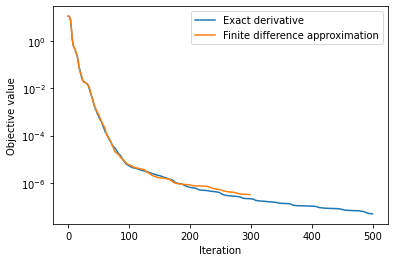

In [32]:
plt.semilogy(convergence_exact, label='Exact derivative')
plt.semilogy(convergence_fd, label='Finite difference approximation')
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.legend()

The algorithm using finite differences fails after ~300 iterations due to loss of precision! Using exact derivatives, the algorithm keeps going and is able to reduce the objective further.